In [11]:
from PIL import Image
import numpy as np
import cv2 as cv 
import torch
from torchvision.models import vgg19
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

Sample Images from data set


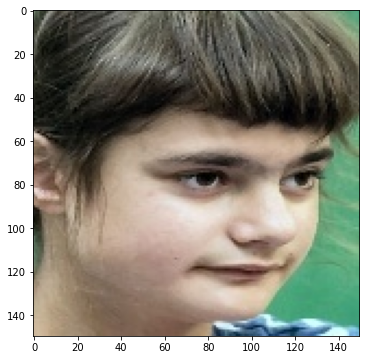

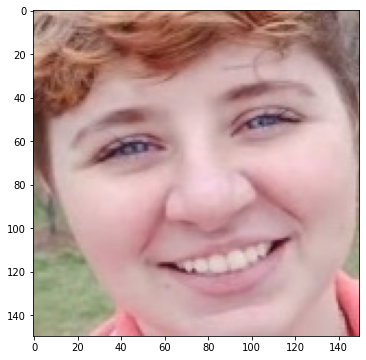

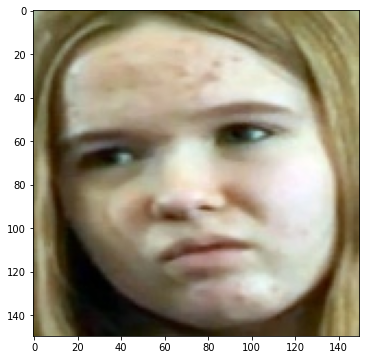

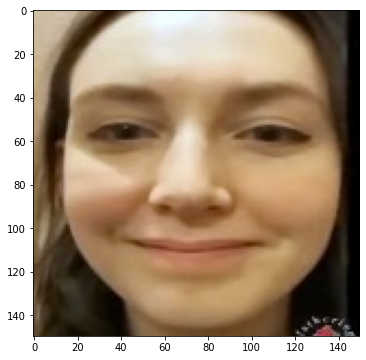

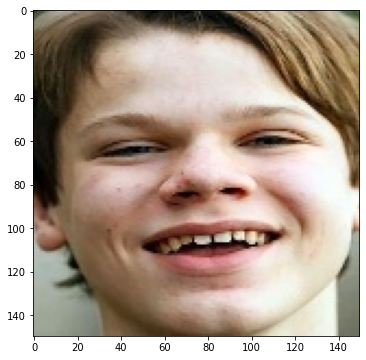

In [4]:
from display import display_images_from_folder

print('Sample Images from data set')
path = 'autism_image_data/consolidated/autistic/'
display_images_from_folder(path, num_images=5)

In [14]:
vgg = vgg19(pretrained=True)

for i, (name, param) in enumerate(vgg.named_parameters()):
    if param.requires_grad:
        if i >= 32:
            param.requires_grad = True
        else:
            param.requires_grad = False

for i, (name, param) in enumerate(vgg.named_parameters()):
    if param.requires_grad:
        print(name, i)



classifier.0.weight 32
classifier.0.bias 33
classifier.3.weight 34
classifier.3.bias 35
classifier.6.weight 36
classifier.6.bias 37


In [33]:
import torch
import torch.nn as nn
import torchvision.models as models

class RecognitionModel(nn.Module):
    def __init__(self):
        super(RecognitionModel, self).__init__()

        # Load VGG19 model
        self.base = models.vgg19(pretrained=True)
        
        # Modify the VGG19 classifier
        self.base.classifier = nn.Identity()  # Remove the default classifier layers
        
        # Define the remaining layers
        self.global_max_pooling = nn.AdaptiveMaxPool2d(1)
        
        # Calculate the output size of the VGG19 classifier
        vgg19_output_size = self._get_vgg19_output_size()
        
        self.dense1 = nn.Linear(in_features=vgg19_output_size, out_features=512)
        self.dense2 = nn.Linear(in_features=512, out_features=128)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.dropout = nn.Dropout(p=0.2)
        self.dense3 = nn.Linear(in_features=128, out_features=64)
        self.dense4 = nn.Linear(in_features=64, out_features=32)
        self.dense5 = nn.Linear(in_features=32, out_features=2)
        self.softmax = nn.Softmax(dim=1)
    
    def _get_vgg19_output_size(self):
        # Dummy forward pass to get the output size of the VGG19 classifier
        dummy_input = torch.zeros(1, 3, 224, 224)
        features = self.base.features(dummy_input)
        avgpool = self.base.avgpool(features)
        output_size = avgpool.shape[1] * avgpool.shape[2] * avgpool.shape[3]
        return output_size
    
    def forward(self, x):
        # Apply the VGG19 base layers
        x = self.base.features(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Apply the classifier layers
        x = self.dense1(x)
        x = nn.ReLU()(x)
        x = self.dense2(x)
        x = nn.ReLU()(x)
        x = self.dense3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.dense4(x)
        x = nn.ReLU()(x)
        x = self.dense5(x)
        x = self.softmax(x)
        
        return x


In [34]:

# Define the transforms for data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = datasets.ImageFolder(root='autism_image_data/train/', transform=data_transforms)
test_dataset = datasets.ImageFolder(root='autism_image_data/test', transform=data_transforms)
valid_dataset = datasets.ImageFolder(root='autism_image_data/valid', transform=data_transforms)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)


In [35]:
learning_rate = 0.001
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()


In [36]:
model = RecognitionModel().to(device)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [38]:
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate the model after each epoch
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Calculate accuracy
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = 100 * total_correct / total_samples
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')


KeyboardInterrupt: 